In [14]:
import warnings
warnings.simplefilter("ignore")

We import pandas library to start our work

In [15]:
import pandas as pd

`cleanFRED()` is used to clean up data which is in the FRED Format<br>
`cleadOECD()` is used to clean up data which is in the OECD Format

In [16]:
def cleanFRED(df, indicator):
    df = df.rename(columns={df.keys()[1]:indicator})
    df['DATE'] = pd.to_datetime(df['DATE'])
    df['year'] = pd.to_numeric(df['DATE'].dt.strftime('%Y'))
    df = df.drop(columns=['DATE'])
    df = df.reindex(columns=['year',indicator])
    return df
def cleanOECD(df, indicator):
    df.rename(columns={'TIME': 'year', 'LOCATION':'countrycode', 'Value': indicator}, inplace=True) 
    filter = df['countrycode']=='JPN'
    df.drop(columns=['INDICATOR', 'MEASURE', 'FREQUENCY','SUBJECT', 'Flag Codes','countrycode'], inplace=True)
    df = df[filter]
    return df
def cleanCEIC(df, indicator):
    df.rename(columns={'observation_date':'year', df.keys()[1]: indicator}, inplace=True)
    df['year'] = pd.to_numeric(df['year'].dt.strftime('%Y'))
    return df
def cleanNomGDP(df, indicator):
    df.rename(columns={'TIME': 'year', 'LOCATION':'countrycode', 'Value': indicator}, inplace=True) 
    filter = df['countrycode']=='JPN'
    df = df[df['MEASURE']=='MLN_USD']
    df = df[filter]
    df.drop(columns=['INDICATOR', 'MEASURE', 'FREQUENCY','SUBJECT', 'Flag Codes','countrycode'], inplace=True)
    
    return df

Reading all the data files and merging them together

In [17]:
datasets = []
read = pd.read_csv('Data/Nominal GDP Million USD 1960-2022.csv')
nom_gdp = cleanNomGDP(read, 'nom_gdp')
datasets.append(nom_gdp)

read = pd.read_csv('Data/Capital Stock at Constant National Prices Millions USD 2017.csv')
capital_stock = cleanFRED(read, 'capital_stock')
datasets.append(capital_stock)

read = pd.read_csv("Data/Working Age 15-24.csv")
population = cleanFRED(read, 'population')
datasets.append(population)

read = pd.read_csv('Data/Real GDP at Constant National Prices Millions USD 2017.csv')
real_gdp = cleanFRED(read, 'real_gdp')
datasets.append(real_gdp)

read = pd.read_csv('Data/Investment GCFC Millions USD (1960-2021).csv')
investment = cleanOECD(read, 'investment')
datasets.append(investment)

read = pd.read_excel('Data/Share of Labour Compensation in GDP at Current National Prices for Japan.xls',header=10)
share_of_labour_compensation = cleanCEIC(read, 'share_of_labour_compensation')
datasets.append(share_of_labour_compensation)

indirect_tax = pd.read_excel("Data/Indirect Taxes.xlsx")
datasets.append(indirect_tax)

In [18]:
data=pd.DataFrame(columns=['year'])
for d in datasets:
    data = pd.merge(data, d, on='year', how='right', validate='one_to_one')
data.dropna(inplace=True)
data = data[data['year']>=1980]
data.reset_index(drop=True,inplace=True)

In [19]:
data['population'] = pd.to_numeric(data['population'])


# Calilbration

$$
\max_{c_t,k_{t+1}}{{\sum_{t=0}^{\infty}{\beta^{t}[\log({\tilde{c_t}})+t\log({\gamma})]}}}
$$
Subject to:
$$
\tilde{c_t} + n \gamma \tilde{k_{t+1}} - (1-\delta)\tilde{k_t} = \theta \tilde{k_t}
$$

Adjusting the Inflation for inflation since the data is in current year prices, we use the GDP deflator method, which is 
$$
I_{real} = I_{nominal} * \frac{GDP_{real}}{GDP_{nominal}}
$$

In [20]:
data['adj_i'] = data['investment'] * (data['real_gdp']/data['nom_gdp'])

Now we need to find the growth rate of per capita gdp

In [21]:
data['gdppc'] = data['real_gdp']/data['population']
data['g'] = data.gdppc.pct_change()

Calculating delta using 
$$
K_{t+1} = (1-\delta)K_{t} + I_{t}
$$


Where $k_{t}$ and $k_{t+1}$ are capital in current and next periods,<br> $\delta$ is depreciation,<br> and $i_{t}$ is investment.

Afer rearranging, the equation above gives us
$$
\delta =  \frac{K_{t} - K_{t+1} + i_{t}}{K_{t}}
$$

finding delta using log variables

$$
log({\delta}) = \frac{log({K_t}) - log({K_{t+1}}) + log({I_{t}})}{log({K_t})}
$$

finding delta using real variables

In [22]:
g = data['g'].mean(skipna=True)

In [23]:
deltas = []
for i,cols in data.iterrows():
    if i+1==data.shape[0]:
        break
    kt=data.loc[i]['capital_stock']
    kt1=data.loc[i+1]['capital_stock']
    it=data.loc[i]['adj_i']
    delta = (kt-kt1+it)/kt
    deltas.append(delta)
deltas.append(0)
data.insert(data.shape[1],'delta',deltas)

In [24]:
delta = data['delta'].mean(skipna=True)

Now we graph `delta` to see the deviation

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

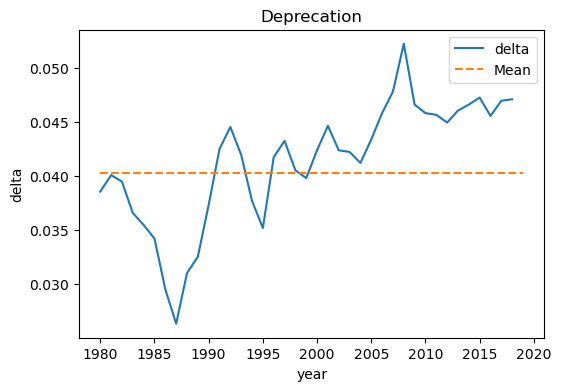

In [26]:
plt.figure(figsize=(6,4))
plt.title('Deprecation')
plt.plot('year','delta', data=data[data['delta']!=0], label='delta')
plt.ylabel('delta')
plt.xlabel('year')
plt.plot(data['year'],[data['delta'].mean()]*data.shape[0], label='Mean', linestyle='--')
plt.legend()
plt.savefig('Graphs/delta.png')

In [27]:
data['pop_growth'] = data.population.pct_change()
n = data['pop_growth'].mean()

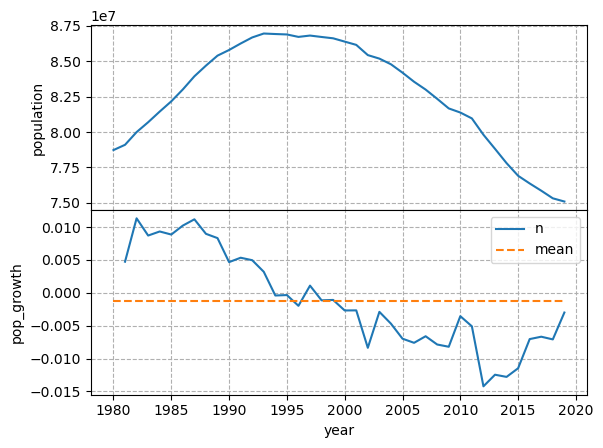

In [28]:
fig, ax = plt.subplots(2,1, sharex=True, gridspec_kw = {'wspace':0, 'hspace':0})
ax[1].plot(data['year'], data['pop_growth'], label='n')
ax[1].set(xlabel='year', ylabel='pop_growth')
ax[1].plot(data['year'], [data['pop_growth'].mean()]*data.shape[0], label='mean', linestyle='--')
ax[1].legend()
ax[1].grid()

ax[0].plot(data['year'], data['population'], label='population')
ax[0].set(ylabel='population')


for a in ax.flatten():
    a.grid('on', linestyle='--')

plt.savefig("Graphs/n.png")

$$
\alpha = \frac{K_{t}}{Y_{t}}
$$ 
and
$$
log({\alpha}) = \frac {log({K_{t}})}{log({Y_{t}})}
$$

Calculating `delta` using the Labour Shares

$$
1 - \alpha = \frac{Y_t w_t}{Y_t - \text{Indirect Tax}}
$$

In [29]:
data['1-alpha'] = (data['share_of_labour_compensation']*data['real_gdp'])/(data['real_gdp']-data['Indirect Tax'])

In [30]:
data['alpha'] = 1-data['1-alpha']
alpha = data['alpha'].mean(skipna=True)

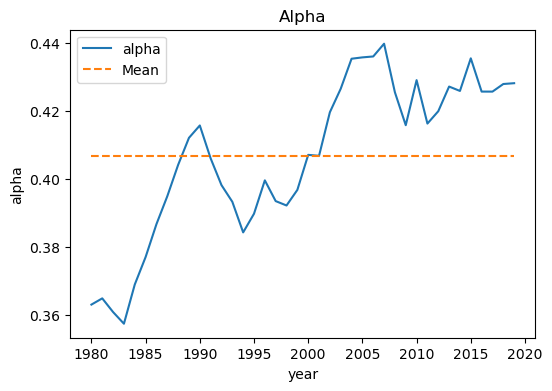

In [31]:
plt.figure(figsize=(6,4))
plt.title('Alpha')
plt.ylabel('alpha')
plt.xlabel('year')
plt.plot('year','alpha', data=data[data['alpha']!=0], label='alpha')
plt.plot(data['year'],[data['alpha'].mean()]* data.shape[0], label='Mean', linestyle='--')
plt.legend()
plt.savefig('Graphs/alpha.png')

Finding $\gamma$

$$
\log({\gamma}) = \log({\frac{Y_{t+1}}{N_{t+1}}}) - \log({\frac{Y_t}{N_t}})
$$

In [32]:
from numpy import log, exp

In [33]:
gammas = []
for i,cols in data.iterrows():
    if i+1==data.shape[0]:
        break
    yt = data.loc[i]['real_gdp']
    yt_1 = data.loc[i+1]['real_gdp']
    Nt = data.loc[i]['population']
    Nt_1 = data.loc[i+1]['population']
    ln_gamma = log(yt_1/Nt_1) - log(yt/Nt)
    gammas.append(ln_gamma)
gammas.append(0)
data.insert(data.shape[1],'gamma',gammas)

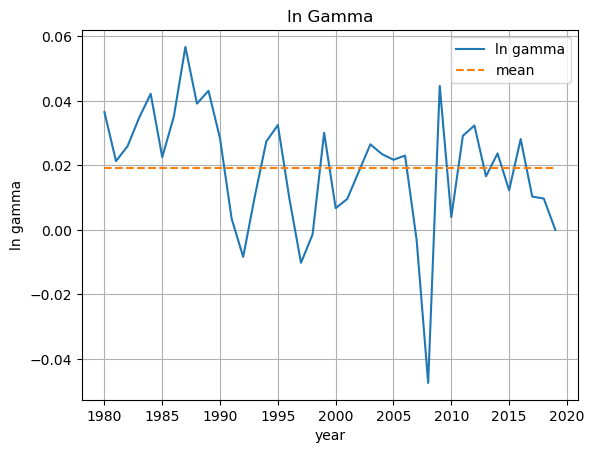

In [34]:
fig, ax = plt.subplots()
ax.plot(data['year'], data['gamma'], label='ln gamma')
ax.set(xlabel='year', ylabel='ln gamma', title='ln Gamma')
ax.plot(data['year'], [data['gamma'].mean()]*data.shape[0], label='mean', linestyle='--')
ax.legend()
ax.grid()
plt.savefig("Graphs/gamma.png")

In [35]:
data['gamma'] = exp(data['gamma'])
gamma = data['gamma'].mean(skipna=True)

$$
r = \frac{\alpha Y_t}{K_t}
$$

In [36]:
data['r'] = data['alpha'] * data['real_gdp']/data['capital_stock']
r = data['r'].mean(skipna=True)

We can now use $\gamma$ to calculate the effective variables

$$
\tilde{y_t} = \frac{Y_t}{\gamma^t N_t}
$$
$$
\tilde{k_t} = \frac{K_t}{\gamma^t N_t}
$$

In [37]:
data['eff_yt'] = (data['real_gdp']/(gamma*data['population']))*1000000
data['eff_kt'] = data['capital_stock'] / ((gamma**data.index) * data['population'])
data['eff_kt^alpha'] = (data['eff_kt'] * 1000000) ** (data['alpha'])
data['theta'] = data['eff_yt']/data['eff_kt^alpha']
theta = data['theta'].mean(skipna=True)

Plotting $\theta$


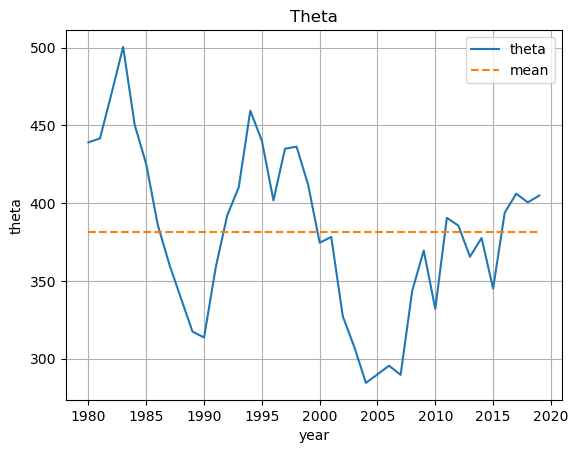

In [38]:
fig, ax = plt.subplots()
ax.plot(data['year'], data['theta'], label='theta')
ax.set(xlabel='year', ylabel='theta', title='Theta')
ax.plot(data['year'], [data['theta'].mean()]*data.shape[0], label='mean', linestyle='--')
ax.legend()
ax.grid()
plt.savefig("Graphs/theta.png")

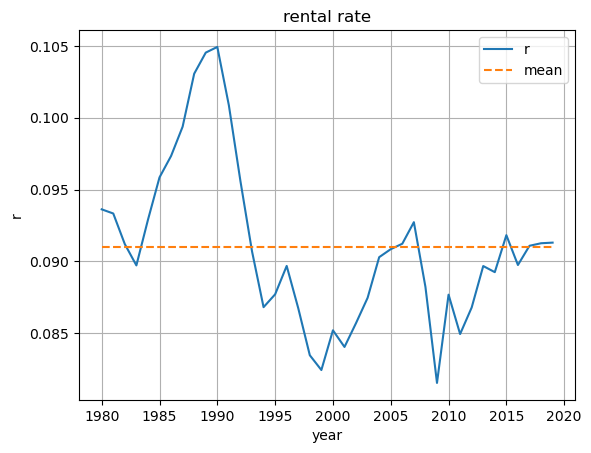

In [39]:
fig, ax = plt.subplots()
ax.plot(data['year'], data['r'], label='r')
ax.set(xlabel='year', ylabel='r', title='rental rate')
ax.plot(data['year'], [data['r'].mean()]*data.shape[0], label='mean', linestyle='--')
ax.legend()
ax.grid()
plt.savefig("Graphs/r.png")

$$\frac{C_{t+1}}{C_t} = \beta (1-\delta + \alpha A_{t+1} K_{t+1}^{a-1} L_{t+1}^{^{-\alpha}})$$

In [40]:
data['Cons'] = data['real_gdp'] - data['adj_i']
Beta = []
for i,cols in data.iterrows():
    if i+1==data.shape[0]:
        break
    yt_1 = data.loc[i+1]['real_gdp']
    kt_1 = data.loc[i+1]['capital_stock']
    d = data.loc[i]['delta']
    al = data.loc[i]['alpha']
    Ct = data.loc[i]['Cons']
    Ct_1 = data.loc[i+1]['Cons']
    b = Ct / (Ct_1*(1-d+al*yt_1/kt1))

    Beta.append(b)
Beta.append(0)
data.insert(data.shape[1],'beta',Beta)

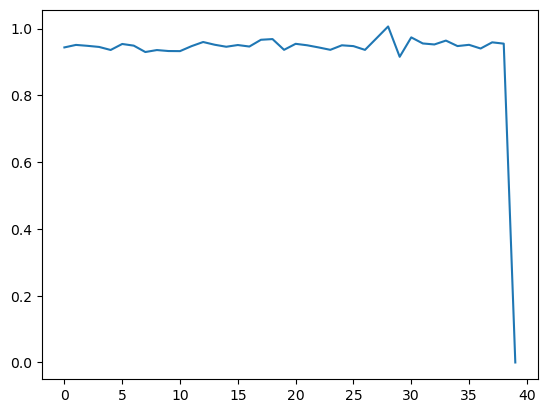

In [41]:
data.beta.plot()
beta = data['beta'].mean()

In [42]:
data = data.drop(index=data.shape[0]-1)
beta = data.beta.mean()
gamma = data.gamma.mean()
alpha = data.alpha.mean()
delta = data.delta.mean()
theta = data.theta.mean()
g = data.g.mean()
r = data.r.mean()
n = data.pop_growth.mean()

In [43]:
parameters = {
        'g': round(g,4),
        'gamma': round(gamma,4),
        'alpha': round(alpha,2),
        'n': round(n,4),
        'delta': round(delta,4),
        'r': round(r,4),
        'theta': round(theta,4),
        'beta': round(beta,4)
}

In [44]:
parameters

{'g': 0.0203,
 'gamma': 1.0201,
 'alpha': 0.41,
 'n': -0.0011,
 'delta': 0.0414,
 'r': 0.091,
 'theta': 380.6434,
 'beta': 0.9497}

In [45]:
splits = [(1980,1992), (1992,2000), (2000,2010), (2010,2019)]
df_splits = []
p ={}
p[(1980,2019)] = parameters
for split in splits:
    t = data[(data['year']>=split[0]) & (data['year']<=split[1])]
    t.reset_index(drop=True, inplace=True)
    df_splits.append(t)
    beta = t.beta.mean()
    gamma = t.gamma.mean()
    alpha = t.alpha.mean()
    delta = t.delta.mean()
    theta = t.theta.mean()
    g = t.g.mean()
    r = t.r.mean()
    n = t.pop_growth.mean()
    p[split] = {
        'g': round(g,2),
        'gamma': round(gamma,4),
        'alpha': round(alpha,4),
        'n': round(n,2),
        'delta': round(delta,4),
        'r': round(r,2),
        'theta': round(theta,4),
        'beta': round(beta,4)
    }
print(p)

{(1980, 2019): {'g': 0.0203, 'gamma': 1.0201, 'alpha': 0.41, 'n': -0.0011, 'delta': 0.0414, 'r': 0.091, 'theta': 380.6434, 'beta': 0.9497}, (1980, 1992): {'g': 0.03, 'gamma': 1.0299, 'alpha': 0.3855, 'n': 0.01, 'delta': 0.036, 'r': 0.1, 'theta': 399.5426, 'beta': 0.9434}, (1992, 2000): {'g': 0.01, 'gamma': 1.0109, 'alpha': 0.395, 'n': 0.0, 'delta': 0.0408, 'r': 0.09, 'theta': 417.9553, 'beta': 0.9533}, (2000, 2010): {'g': 0.01, 'gamma': 1.0119, 'alpha': 0.4253, 'n': -0.01, 'delta': 0.0449, 'r': 0.09, 'theta': 326.4854, 'beta': 0.9531}, (2010, 2019): {'g': 0.02, 'gamma': 1.0187, 'alpha': 0.426, 'n': -0.01, 'delta': 0.0462, 'r': 0.09, 'theta': 377.4017, 'beta': 0.9554}}


$$
\frac{\delta{Y}}{Y} = \alpha\frac{\delta{K}}{K} + (1-\alpha)\frac{\delta{L}}{L} + TFP
$$

In [46]:
for split in splits:
    print(p[split])
    break

{'g': 0.03, 'gamma': 1.0299, 'alpha': 0.3855, 'n': 0.01, 'delta': 0.036, 'r': 0.1, 'theta': 399.5426, 'beta': 0.9434}


In [47]:
data

,year,nom_gdp,capital_stock,population,real_gdp,investment,share_of_labour_compensation,Indirect Tax,adj_i,gdppc,...,1-alpha,alpha,gamma,r,eff_yt,eff_kt,eff_kt^alpha,theta,Cons,beta
0,1980,1050471.090,9613282.0,7.872644e+07,2478574.00,363244.509,0.620528,63664.047710,8.570711e+05,0.031483,...,0.636887,0.363113,1.037191,0.093621,30878.895849,0.122110,70.317955,439.132450,1.621503e+06,0.943586
1,1981,1198859.753,10099709.0,7.909857e+07,2582905.50,401763.712,0.618410,67696.625037,8.655872e+05,0.032654,...,0.635055,0.364945,1.021554,0.093331,32027.305302,0.125234,72.508354,441.705038,1.717318e+06,0.951085
2,1982,1314677.302,10560476.0,7.999449e+07,2668463.00,425651.562,0.622449,69460.017617,8.639652e+05,0.033358,...,0.639085,0.360915,1.026294,0.091198,32717.612163,0.126994,69.508008,470.702773,1.804498e+06,0.948333
3,1983,1415765.104,11007563.0,8.069107e+07,2762474.25,442727.337,0.626040,70833.433704,8.638600e+05,0.034235,...,0.642514,0.357486,1.035365,0.089715,33577.880533,0.128708,67.082716,500.544439,1.898614e+06,0.945020
4,1984,1531542.366,11468706.0,8.144352e+07,2886840.50,472626.371,0.614821,73921.013141,8.908646e+05,0.035446,...,0.630978,0.369022,1.043091,0.092888,34765.360955,0.130311,77.186256,450.408697,1.995976e+06,0.935915
5,1985,1661500.325,11952732.0,8.216517e+07,3037920.00,508256.257,0.605987,82452.870031,9.293058e+05,0.036973,...,0.622893,0.377107,1.022810,0.095846,36263.448674,0.132033,85.319067,425.033346,2.108614e+06,0.953869
6,1986,1750794.139,12472975.0,8.300503e+07,3138977.25,536358.562,0.596799,84046.561842,9.616307e+05,0.037817,...,0.613218,0.386782,1.035733,0.097338,37090.633653,0.133767,96.112165,385.909875,2.177347e+06,0.948900
7,1987,1877492.604,13066164.0,8.393255e+07,3287471.75,597276.967,0.588817,87996.969862,1.045826e+06,0.039168,...,0.605012,0.394988,1.058358,0.099380,38415.996960,0.135919,106.558154,360.516727,2.241645e+06,0.929796
8,1988,2073203.225,13767501.0,8.468530e+07,3510527.50,693029.839,0.579881,93689.108400,1.173498e+06,0.041454,...,0.595781,0.404219,1.039931,0.103070,40657.892483,0.139217,119.998314,338.820532,2.337029e+06,0.935671
9,1989,2260605.047,14513620.0,8.538962e+07,3681070.00,773086.971,0.577071,67345.564335,1.258861e+06,0.043109,...,0.587825,0.412175,1.044055,0.104539,42281.414652,0.142756,133.227491,317.362539,2.422209e+06,0.932754


In [48]:
df_splits = []
ga = {}
final_ga = {}
for split in splits:
    t = data[(data['year']>=split[0]) & (data['year']<=split[1])]
    t.reset_index(drop=True, inplace=True)
    Y0 = t['real_gdp'].loc[0]
    Y1 = t['real_gdp'].loc[t.shape[0]-1]

    count = t.shape[0]

    Y = (((Y1/Y0)**(1/count))-1)

    K0 = t['capital_stock'].loc[0]
    K1 = t['capital_stock'].loc[t.shape[0]-1]

    K = (((K1/K0)**(1/count))-1)

    
    PERIOD = t.shape[0]-1
    L0 = t['population'].loc[0]
    L1 = t['population'].loc[t.shape[0]-1]
    L = (((L1/L0)**(1/count))-1)

    ALPHA = t.alpha.mean()
    ONE_ALPHA = t['1-alpha'].mean()

    ALPHAK = K * ALPHA
    ONE_ALPHAL = L * ONE_ALPHA


    ga[split] = {
        "Y": Y,
        "K": K,
        "L": L,
        "alpha": ALPHA,
        "1-alpha": ONE_ALPHA,
        "alpha*K": ALPHAK,
        "1-alpha*L": ONE_ALPHAL,
        'TFP': Y-(ALPHAK+ONE_ALPHAL)
    }

    final_ga[split] = {
        "Total Output": round(Y,4),
        "Capital": round(ALPHAK,4),
        "Labour": round(ONE_ALPHAL,4),
        "TFP": round((Y-ALPHAK-ONE_ALPHAL),4),
    }

In [49]:
final_ga

{(1980, 1992): {'Total Output': 0.038,
  'Capital': 0.0169,
  'Labour': 0.0046,
  'TFP': 0.0166},
 (1992, 2000): {'Total Output': 0.0097,
  'Capital': 0.0099,
  'Labour': -0.0002,
  'TFP': -0.0001},
 (2000, 2010): {'Total Output': 0.0058,
  'Capital': 0.0034,
  'Labour': -0.0031,
  'TFP': 0.0055},
 (2010, 2019): {'Total Output': 0.0088,
  'Capital': 0.0017,
  'Labour': -0.0049,
  'TFP': 0.012}}

In [50]:
with pd.ExcelWriter("processed data/decades2.xlsx") as writer:
    pd.DataFrame.from_dict(p, orient='index').to_excel(writer, sheet_name='parameters2')
    pd.DataFrame.from_dict(final_ga, orient='columns').to_excel(writer, sheet_name='growth accounting')
    pd.DataFrame.from_dict(p, orient='columns').to_excel(writer, sheet_name='parameters2 transpose')


In [51]:
with pd.ExcelWriter("processed data/data.xlsx") as writer:
    data.to_excel(writer, sheet_name="data",index=False)
    pd.DataFrame.from_dict(p, orient='index').to_excel(writer, sheet_name='parameters')
    pd.DataFrame.from_dict(final_ga, orient='index').to_excel(writer, sheet_name='growth accounting')
    pd.DataFrame.from_dict(ga, orient='index').to_excel(writer, sheet_name='growth accounting2')

<Axes: title={'center': 'r - delta'}, xlabel='year'>

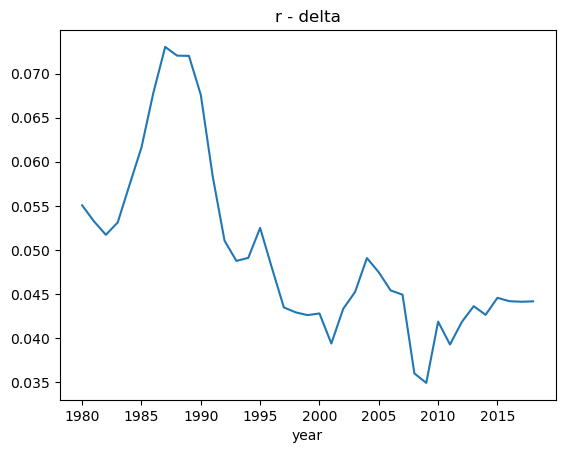

In [52]:
data['K/Y'] = data['capital_stock']/data['real_gdp']
copy_data = data.set_index('year')
copy_data['r-d'] = copy_data['r']-copy_data['delta']
copy_data['r-d'].plot(title='r - delta')

<Axes: title={'center': 'Capital Output Ratio'}, xlabel='year'>

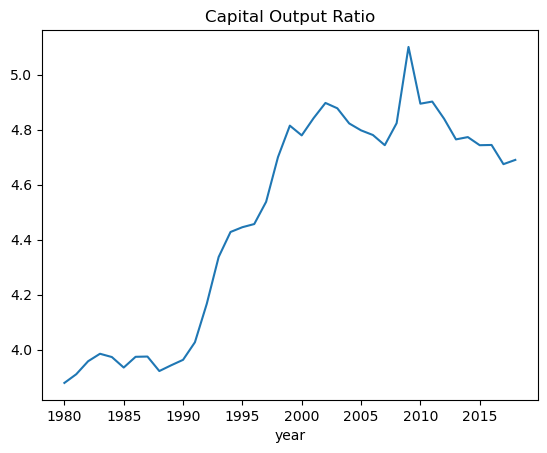

In [53]:
copy_data['K/Y'].plot(title='Capital Output Ratio')

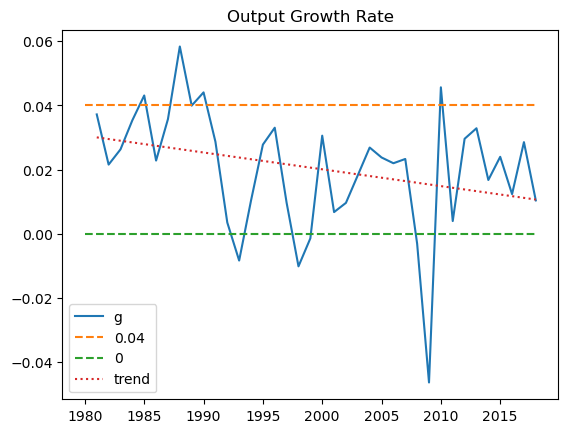

In [54]:
# copy_data['g'].plot(title='Capital Growth')
import numpy as np
fig,ax = plt.subplots()
ax.plot(data['year'],data['g'], label='g')
ax.plot( data['year'],[0.04]*data.shape[0], linestyle='--', label='0.04')
ax.plot( data['year'],[0]*data.shape[0], linestyle='--', label='0')

copy_data.dropna(inplace=True)
x = copy_data.index
y= copy_data['g']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax.plot(x, p(x), linestyle=":", label='trend')
ax.legend()
ax.set_title('Output Growth Rate')
plt.show()

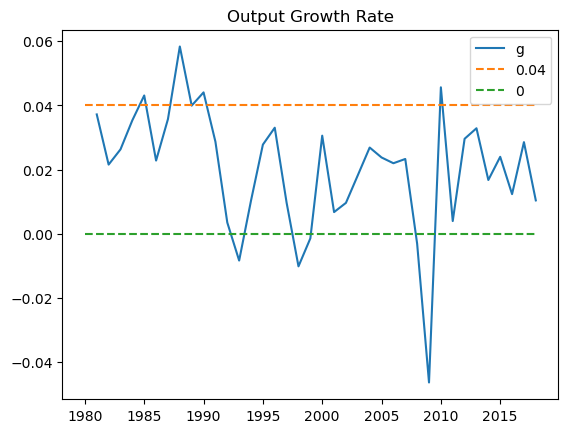

In [55]:
fig,ax = plt.subplots()
ax.plot(data['year'],data['g'], label='g')
ax.plot( data['year'],[0.04]*data.shape[0], linestyle='--', label='0.04')
ax.plot( data['year'],[0]*data.shape[0], linestyle='--', label='0')
ax.legend()
ax.set_title('Output Growth Rate')
plt.show()